In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

/home/coda/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
import numpy as np

In [4]:
from scipy.constants import g, C2K, K2C

In [5]:
import weight_shell

In [6]:
sonde = weight_shell.read_sonde('91408_2011_07_19_12.txt')
levels = weight_shell.interpolate_sounding(sonde)
atmos = weight_shell.create_atmosphere(levels)

Successfully opened file  91408_2011_07_19_12.txt
93  levels in raw input sounding
269  levels in interpolated sounding
    p [Pa]    T [C] Td [C]  T [K]     q []
268  layers in model atmosphere
Total precipitable water =  57.7460405625  kg/m^2


In [7]:
def get_weighting_function_upwelling(f, layers, mu=1.):
    import gasabsr98
    layers['ke_air'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[0], axis=1)
    layers['ke_wv'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[1], axis=1)
    
    layers['tau'] = (layers.ke_air*(layers.mass - layers.wvmass) + layers.ke_wv*layers.wvmass)
    layers = layers.reset_index(drop=True)
    layers['tx_from_top'] = (layers
                    # Take tau(z)
                     .sort_values('Zbar', ascending=False).tau
                    # Compute total optical depths from toa to z for each z
                     .cumsum()
                    # Compute tx = e^(-tau/mu)
                    .apply(lambda tau: np.exp(-tau/mu)))
    
    # Compute the contribution from each layer
    layers['layer_weight'] = -(layers.sort_values('Zbar', ascending=False).tx_from_top.diff())
    
    # Get weight for each layer in m^-1
    layers['weighting_function'] = layers.layer_weight / layers.sort_values('Zbar', ascending=True).Zbar.diff() * 1000
    return layers

In [8]:
def get_weighting_function_downwelling(f, layers, mu=1):
    import gasabsr98
    layers['ke_air'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[0], axis=1)
    layers['ke_wv'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[1], axis=1)
    
    layers['tau'] = (layers.ke_air*(layers.mass - layers.wvmass) + layers.ke_wv*layers.wvmass)
    layers = layers.reset_index(drop=True)
    layers['tx_from_bottom'] = (layers
                    # Take tau(z)
                     .sort_values('Zbar', ascending=True).tau
                    # Compute total optical depths from toa to z for each z
                     .cumsum()
                    # Compute tx = e^(-tau/mu)
                    .apply(lambda tau: np.exp(-tau/mu)))
    
    # Compute the contribution from each layer
    layers['layer_weight'] = (layers.sort_values('Zbar', ascending=False).tx_from_bottom.diff())
    
    # Get weight for each layer in m^-1
    layers['weighting_function'] = layers.layer_weight / -layers.sort_values('Zbar', ascending=False).Zbar.diff() * 1000
    return layers

In [9]:
def get_weighting_function_satellite(f, layers, surf_emis, mu=1):
    refl = 1.0-surf_emis
    down = get_weighting_function_downwelling(f, layers, mu).set_index('Zbar').ix[:, ('weighting_function','layer_weight','tx_from_bottom')]
    up = get_weighting_function_upwelling(f, layers, mu).set_index('Zbar').ix[:,('weighting_function', 'layer_weight','tx_from_top')]
    both = down*refl*up.tx_from_top.min() + up
    both['tx_from_top'] = up.tx_from_top
    both['tx_from_bottom'] = down.tx_from_bottom
    return both
    

In [10]:
amsu_a = pd.Series(
    {
        3:  50.3000,
        4:  52.8000,
        5:  53.7110,
        6:  54.4000,
        7:  54.9400,
        8:  55.5000,
        9:  57.2900,
        10: 57.5070
    }
)

amsu_b = pd.Series(
    {
       16: 89.00,
        17: 150.0,
        18: 184.31,
        19: 186.31,
        20: 190.31
    }
)

In [11]:
weighting_functions_a = pd.DataFrame({ channel:get_weighting_function_satellite(amsu_a[channel], atmos, .5).weighting_function for channel in amsu_a.index})
weighting_functions_b = pd.DataFrame({ channel:get_weighting_function_satellite(amsu_b[channel], atmos, .5).weighting_function for channel in amsu_b.index})

(0, 0.12)

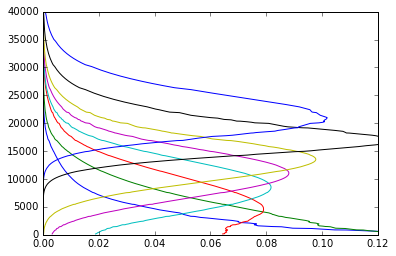

In [12]:
plot(weighting_functions_a.values, weighting_functions_a.index)
#plot(weighting_functions_b, weighting_functions_b.index)
#legend(amsu_a.index, loc='best')
ylim([0,40000])
xlim([0,.12])

For all experiments
* Take the surface skin temperature Ts to be the same as the temperature of the lowest atmospheric level T0 in your sounding.

In [13]:
def get_skin_temp(sonde):
    return sonde[0].TempK

* Take the surface emissivity to be 1.0 except where instructed otherwise.

In [14]:
surface_emissivity = 1.0

* Assume nadir viewing (θ=0) except where instructed otherwise.

In [15]:
mu = 1

# Experiments

Compute and plot the weighting functions for channels 3-10 for both soundings (same plot, use colors and/or dashes to distinguish between soundings). 

In [16]:
sonde_brazil = weight_shell.read_sonde('brazil.txt')
levels = weight_shell.interpolate_sounding(sonde_brazil)
brazil = weight_shell.create_atmosphere(levels)

sonde_canada = weight_shell.read_sonde('canada.txt')
levels = weight_shell.interpolate_sounding(sonde_canada)
canada = weight_shell.create_atmosphere(levels)

Successfully opened file  brazil.txt
91  levels in raw input sounding
265  levels in interpolated sounding
    p [Pa]    T [C] Td [C]  T [K]     q []
264  layers in model atmosphere
Total precipitable water =  52.2205992679  kg/m^2
Successfully opened file  canada.txt
126  levels in raw input sounding
225  levels in interpolated sounding
    p [Pa]    T [C] Td [C]  T [K]     q []
224  layers in model atmosphere
Total precipitable water =  3.12065072759  kg/m^2


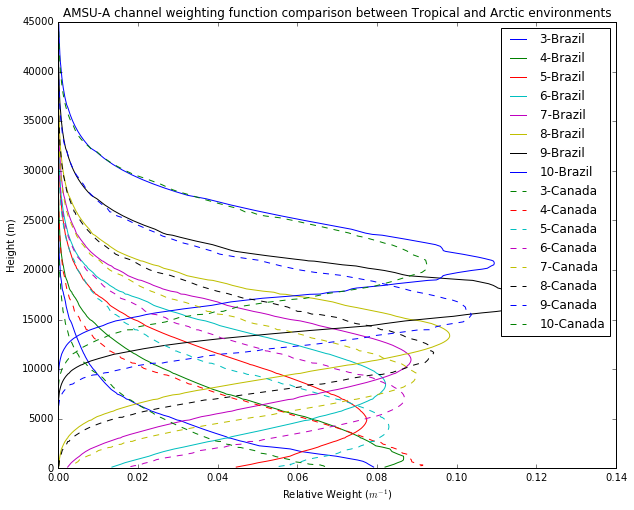

In [45]:
figure(figsize=(10,8))
weighting_functions = pd.DataFrame({
        channel:(get_weighting_function_satellite(amsu_a[channel],
                                                 brazil,
                                                 surface_emissivity,
                                                 mu)
                 .weighting_function) for channel in amsu_a.index})
_ = plot(weighting_functions, weighting_functions.index)

weighting_functions = pd.DataFrame({
        channel:(get_weighting_function_satellite(amsu_a[channel],
                                                 canada,
                                                 surface_emissivity,
                                                 mu)
                 .weighting_function) for channel in amsu_a.index})
_ = plot(weighting_functions, weighting_functions.index, linestyle='--')
_ = legend([str(x)+'-Brazil' for x in amsu_a.index]+[str(x)+'-Canada' for x in amsu_a.index],loc='best')
xlabel('Relative Weight ($m^{-1}$)')
ylabel('Height (m)')
title('AMSU-A channel weighting function comparison between Tropical and Arctic environments')
savefig('weighting_a.pdf')

How do the weighting functions differ between the two cases?

* The weighting functions have stronger peaks in Brazil above 10km
* The weighting functions have stronger in Canada below 10km
* The altitude of peak absorption is lower in Canada in every case (channel 2 and 3 peak at surface)

Do the same for channels 18-20.

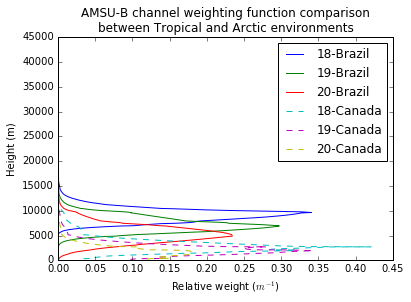

In [44]:
weighting_functions = pd.DataFrame({
        channel:(get_weighting_function_satellite(amsu_b[channel],
                                                 brazil,
                                                 surface_emissivity,
                                                 mu)
                 .weighting_function) for channel in amsu_b.loc[[18,19,20]].index})
_ = plot(weighting_functions, weighting_functions.index)

weighting_functions = pd.DataFrame({
        channel:(get_weighting_function_satellite(amsu_b[channel],
                                                 canada,
                                                surface_emissivity,
                                                 mu)
                 .weighting_function) for channel in amsu_b.loc[[18,19,20]].index})
_ = plot(weighting_functions, weighting_functions.index, linestyle='--')
_ = legend([str(x)+'-Brazil' for x in amsu_b.loc[[18,19,20]].index]+[str(x)+'-Canada' for x in amsu_b.loc[[18,19,20]].index])
ylabel('Height (m)')
xlabel('Relative weight ($m^{-1}$)')
title('AMSU-B channel weighting function comparison\nbetween Tropical and Arctic environments')
savefig('weighting_b.pdf')

Compute and plot (on the same plot) the complete spectra of microwave brightness temperature for the two soundings — 0.1 to 300 GHz at intervals of 0.1 GHz.   Describe the differences in results.   Attribute differences to (a) differences in the surface temperature, (b) differences in the atmospheric temperature profile, and (c) differences in the atmospheric humidity profile.

In [19]:
def bt(f, layers, stemp, surf_emis, mu=1.0):
    wf = get_weighting_function_satellite(f, layers, surf_emis, mu=mu)
    return wf.tx_from_top.min()*stemp*surf_emis + sum(wf.layer_weight * layers.set_index('Zbar').Tbar)

In [20]:
brazil_spec = pd.Series([bt(f, brazil, get_skin_temp(sonde_brazil), surface_emissivity, mu=mu) for f in np.arange(0.1, 300, 1)], index=np.arange(0.1,300,1))
canada_spec = pd.Series([bt(f, canada, get_skin_temp(sonde_canada), surface_emissivity, mu=mu) for f in np.arange(0.1, 300, 1)], index=np.arange(0.1,300,1))

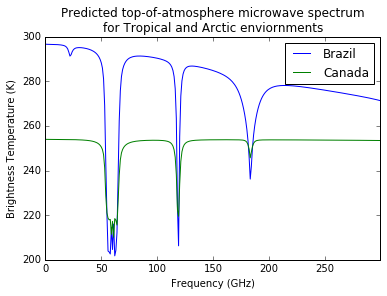

In [21]:
brazil_spec.plot()
canada_spec.plot()
xlabel('Frequency (GHz)')
ylabel('Brightness Temperature (K)')
title('Predicted top-of-atmosphere microwave spectrum\nfor Tropical and Arctic enviornments')
legend(['Brazil','Canada'], loc='best')
savefig('spec.pdf')

#### Differences in surface temp

In [22]:
get_skin_temp(sonde_brazil)

296.75

In [23]:
get_skin_temp(sonde_canada)

254.04999999999998

The surface temperature in Canada is much colder than in Brazil, which by Stephan-Boltzmann's law translates to nearly 85% more emitted broadband flux in Brazil compared to Canada. This effect is evident in the satellite spectrum where at the lowest frequencies the atmosphere should be transparent. The resulting brightness temperatures are about half the actual temperature. This is expected because the emissivity of the surface was assumed to be 50% and Raleigh-Jean's approximation allows the direct application of emissivity to brightness temperatures in the microwave band.

#### Differences in atmospheric temp

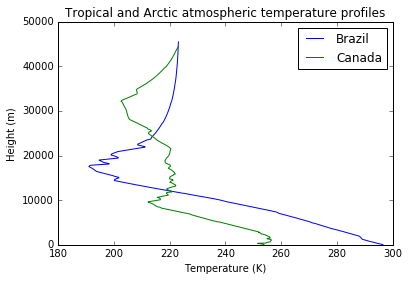

In [24]:
plot(brazil.set_index('Zbar').Tbar, brazil.Zbar)
plot(canada.set_index('Zbar').Tbar, canada.Zbar)
legend(['Brazil','Canada'])
ylabel('Height (m)')
xlabel('Temperature (K)')
title('Tropical and Arctic atmospheric temperature profiles')
savefig('tdry.pdf')

* it appears that Canadian temperatures are warmer than Brazilian temperatures at 17.5 km.
* Below tropopause temps are colder in canada
* In the weighting functions you can see the altitude contributing the most to absorption and emission. Therefore, brightness temperatures will reflect the physical temperature of that layer.
* In channel 18, corresponding to 185 GHz, the altitude of peak absorption is located at about 10km in brazil and 3km in canada. If brightness temperature is read at 185 GHz, it comes out to about 240K for brazil and canada. This matches the temperatures in the profile measured at the altitudes of peak emission, which is to say that the radiative transfer model is working.
* You can see the canadian brightness temperature creep up and brazilian temp dimish as continuom absorption at higher frequences. Here absorption is mostly governed by the water vapor continuum 

#### Differences in atmospheric humidity

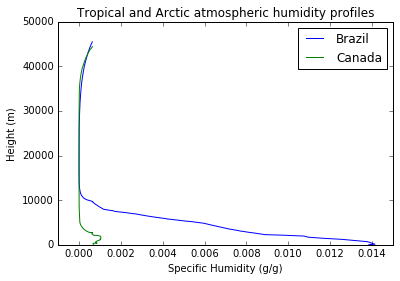

In [25]:
plot(brazil.set_index('Zbar').qbar, brazil.Zbar)
plot(canada.set_index('Zbar').qbar, canada.Zbar)
legend(['Brazil','Canada'])
ylabel('Height (m)')
xlabel('Specific Humidity (g/g)')
title('Tropical and Arctic atmospheric humidity profiles')
xlim([-.001,.015])
savefig('qbar.pdf')

* Brazil has much more moisture than Canada
* Water vapor concentrated in the troposphere and peaking at a few km altitude.
* Brazil total precipitable water much greater

brazil: 52.22  kg/m^2  
canada: 3.12  kg/m^2

* Water vapor is a strong absorber, it has one particularly strong band at 183 GHz
* Oxygen is responsibile for the bands seen at 20, 60, and 118 GHz

For just the tropical sounding, plot the spectra for two cases:  emissivity equal to 1  and emissivity equal to 0.5.  What do your results tell you about the ranges of frequencies for which the atmosphere is opaque?

In [32]:
brazil_spec_emis1 = pd.Series([bt(f, brazil, get_skin_temp(sonde_brazil), 0.5, mu=mu) for f in np.arange(0.1, 300, 1)], index=np.arange(0.1,300,1))

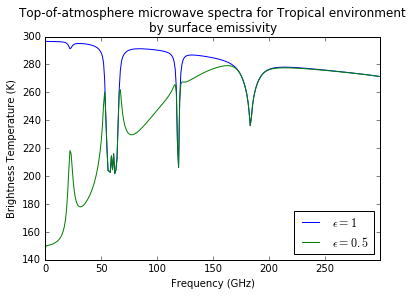

In [35]:
brazil_spec.plot()
brazil_spec_emis1.plot()
xlabel('Frequency (GHz)')
ylabel('Brightness Temperature (K)')
title('Top-of-atmosphere microwave spectra for Tropical environment\nby surface emissivity')
legend(['$\epsilon = 1$','$\epsilon = 0.5$'],loc='best')
savefig('brazil_emiss.pdf')

Repeat the above for the polar sounding and describe what changes relative to the previous results.

In [33]:
canada_spec_emis1 = pd.Series([bt(f, canada, get_skin_temp(sonde_canada), 0.5, mu=mu) for f in np.arange(0.1, 300, 1)], index=np.arange(0.1,300,1))

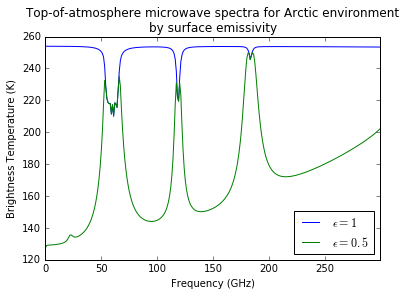

In [34]:
canada_spec.plot()
canada_spec_emis1.plot()
ylabel('Brightness Temperature (K)')
xlabel('Frequency (GHz)')
title('Top-of-atmosphere microwave spectra for Arctic environment\nby surface emissivity')
legend(['$\epsilon = 1$','$\epsilon = 0.5$'],loc='best')
savefig('canada_emiss.pdf')

Again, plot spectra for the tropical sounding, this time for two nadir angles θ:  0 degrees and 55 degrees.  Discuss the resulting differences.

In [49]:
brazil_spec_nonadir = pd.Series([bt(f, brazil, get_skin_temp(sonde_brazil), surface_emissivity, mu=np.cos(np.radians(55))) for f in np.arange(0.1, 300, 1)],
          index=np.arange(0.1,300,1))

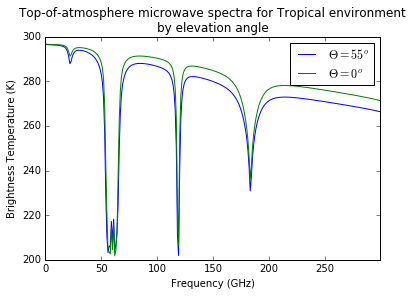

In [50]:
brazil_spec_nonadir.plot()
brazil_spec.plot()
xlabel('Frequency (GHz)')
ylabel('Brightness Temperature (K)')
title('Top-of-atmosphere microwave spectra for Tropical environment\nby elevation angle')
legend(['$ \Theta = 55^o$','$ \Theta = 0^o$'],loc='best')
savefig('brazil_elevation.pdf')

* Most of the difference occurs at lower frequencies
* The received brightness temperature is much higher when viewed at a slant. With the greater optical distance, a much larger component of brightness temperature seems to be coming from the surface. Reflected brightness temperatures off the surface are presumed to be optically thicker as well. This all translates to a greater amount of flux being available at the surface which can be detected by the satellite throught the relatively transparent atmosphere.
* Oxygen absorption at 60 GHz remains about constant. Most radiation in this band is absorbed at high altitudes (in excess of 20km) as can be seen in the channel 10 weighting function.